In [33]:
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np
import unittest

In [34]:
from math import gamma
# Util functions

def gaussian_distribution_density_data(mu, sigma):
    """
        Given a mu and a sigma, this function returns a tuple representing the X and Y of the PDF

        params: mu, sigma <numbers>
        return: X, Y of the normal distribution()
    """
    data = torch.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    gaussian_distribution = (1/(sigma * torch.sqrt(torch.tensor(2) * torch.pi))) * torch.exp(-0.5 * ((data - mu) / sigma)**2)
    return data, gaussian_distribution

def plot(X, mu1, sigma1, mu2, sigma2, title=''):
    # a) Scatter Plot with histograms
    # Histograms
    plt.hist(X, bins=50, alpha=0.25, density = True, histtype='bar', ec='black')
    # Scatter
    plt.scatter(X,torch.zeros(len(X)))
    # Density
    x1, gaussian_density_1 = gaussian_distribution_density_data(mu1, sigma1)
    x2, gaussian_density_2 = gaussian_distribution_density_data(mu2, sigma2)
    plt.plot(x1, gaussian_density_1, label=f'Gaussian (mu={mu1}, sigma={sigma1})', color='red')
    plt.plot(x2, gaussian_density_2, label=f'Gaussian (mu={mu2}, sigma={sigma2})', color='blue')
    if len(title):
        plt.title(title)
    plt.legend()
    plt.show()

# Trabajo Práctico 0: Algoritmo de Maximización de la Esperanza

X =  tensor([ 4.6664,  8.1179,  6.2746,  1.8325,  6.6725,  8.7275, 10.6938, 13.6772,
        17.0624, 16.7670,  5.0077, 12.0766, 11.1854,  4.0438,  6.4525, 14.5663,
        14.2549, 11.6096,  5.6469,  3.6282, 24.6104, 23.1998, 25.8149, 24.3743,
        25.5489, 23.4387, 26.0279, 23.7638, 25.7491, 26.4763, 24.3731, 26.5936,
        28.4611, 25.7136, 23.6588, 23.3886, 20.4290, 24.6433, 24.8428, 23.3443])


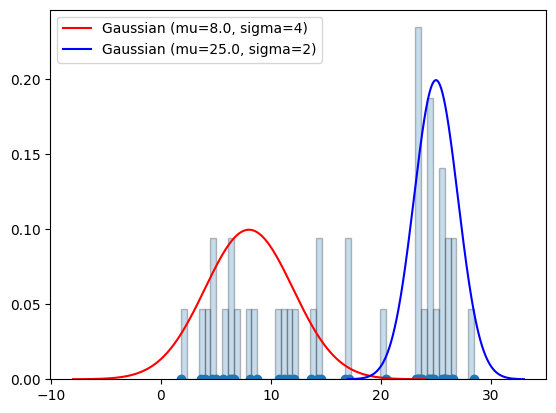

In [35]:
n = 20
mu1 = 8.0
sigma1 = 4
mu2 = 25.0
sigma2 = 2

# 1)
# Generates data that follows two 2gaussian distributions based on a set of parameters.
def generate_data(n, mu1, sigma1, mu2, sigma2):

  # Generate distributions
  normal_dist1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))
  normal_dist2 = torch.distributions.Normal(torch.tensor([mu2]), torch.tensor([sigma2]))

  # Take a sample from each dist
  gaussian_sample1 = normal_dist1.sample((n,1)).squeeze()
  gaussian_sample2 = normal_dist2.sample((n,1)).squeeze()

  # Concatenate the 2 samples
  X =  torch.cat((gaussian_sample1, gaussian_sample2))
  return X

X = generate_data(n, mu1, sigma1, mu2, sigma2)
print('X = ', X)

plot(X, mu1, sigma1, mu2, sigma2)



In [36]:
# 2)
def init_random_parameters(k=2, range=50):
  """
      Generates randombly mu and sigma parameters
      params: k, range
      return: A Kx2 matrix where colum 0 corresponds to mu and column 1 to sigma
  """
  return torch.rand((k, 2))*range

P = init_random_parameters()
print('P = ', P)

P =  tensor([[ 4.8993, 46.3230],
        [23.1841, 25.0985]])


In [37]:
# 3)
def calculate_log_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
  # Nota: tal vez deberíamos poner en el latex el proceso desde la función de likelihood sin log hasta esta versión
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)

likelihood_test = calculate_log_likelihood_gaussian_observation(X[0], mu1, sigma1)
print('likelihood_test = ', likelihood_test)

class LikelihoodGuassianUnitTest(unittest.TestCase):

    def test_likelihood_lower_real(self):
      test_data = torch.distributions.Normal(torch.tensor([4.0]), torch.tensor([8.0]))
      test_gaussian_sample = torch.tensor(test_data.sample((30,1)).squeeze())

      real_lgo = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 4.0, 8.0)
      false_lgo = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 40.0, 7.0)
      self.assertTrue(abs(real_lgo) < abs(false_lgo))

    def test_likelihood_value(self):
      test_gaussian_sample = torch.tensor([0.34, 0.45, 0.78])
      likelihood = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 4.0, 8.0)
      self.assertAlmostEquals(float(likelihood), -3.2824, 3)

unittest.main(argv=[''], verbosity=2, exit=False)

test_likelihood_lower_real (__main__.LikelihoodGuassianUnitTest) ... <ipython-input-37-5ded7ba2f913>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_gaussian_sample = torch.tensor(test_data.sample((30,1)).squeeze())
ok
test_likelihood_value (__main__.LikelihoodGuassianUnitTest) ... <ipython-input-37-5ded7ba2f913>:22: DeprecationWarning: Please use assertAlmostEqual instead.
  self.assertAlmostEquals(float(likelihood), -3.2824, 3)
ok

----------------------------------------------------------------------
Ran 2 tests in 0.011s

OK


likelihood_test =  tensor(-2.6525)


In [38]:
# 4)
def calculate_membership_dataset(X_dataset, Parameters_matrix, k=2):
  N = len(X_dataset)
  #print(N)
  M = torch.zeros(N, k)

  # for each element in X, calculate its likelyhood with each set of parameters from the Parameter Matrix and store the maximum
  for x in range(N):
    # set max likelyhood initially as a very low number (Me suena que esto también podría ponerse de una mejor forma)
    x_max_likelyhood = -999999999
    k_membership = 0
    # iterate over the parameter sets to find which set achieves max likelihood over x
    for k_index, parameters in enumerate(Parameters_matrix):
      #print('Debug: x = ', X_dataset[x], 'params = ', parameters[0], parameters[1])
      x_likelyhood = calculate_log_likelihood_gaussian_observation(X_dataset[x], parameters[0], parameters[1])
      #print('Debug: x_likelyhood = ', x_likelyhood)
      if x_likelyhood > x_max_likelyhood:
        x_max_likelyhood = x_likelyhood
        #print('Debug: max likelyhood = ', x_max_likelyhood)
        k_membership = k_index
    M[x][k_membership] = 1

  return M

M = calculate_membership_dataset(X, P)
print('M = ', M)

M =  tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])


<ipython-input-37-5ded7ba2f913>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


In [39]:
#5)

def recalculate_parameters(X_dataset, Membership_data):
    # TODO: Can we improve this to use torch?
    membership_k1 = Membership_data[:,0]
    membership_k2 = Membership_data[:,1]
    k1_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k1[index] == 1])
    k2_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k2[index] == 1])
    mu_1 = torch.mean(k1_tentative_values)
    mu_2 = torch.mean(k2_tentative_values)
    sigma_1 = torch.std(k1_tentative_values)
    sigma_2 = torch.std(k2_tentative_values)
    return torch.tensor([[mu_1, sigma_1],[mu_2, sigma_2]])

print('Real parameters k1=[{},{}], k2=[{},{}] '.format(mu1, sigma1, mu2, sigma2))
print('Old P parameters: ', P)
P = recalculate_parameters(X, M)
print('New P parameters: ', P)

Real parameters k1=[8.0,4], k2=[25.0,2] 
Old P parameters:  tensor([[ 4.8993, 46.3230],
        [23.1841, 25.0985]])
New P parameters:  tensor([[    nan,     nan],
        [16.9354,  8.5940]])


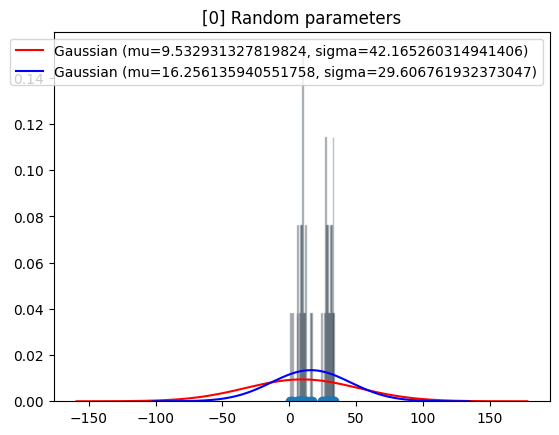

<ipython-input-37-5ded7ba2f913>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


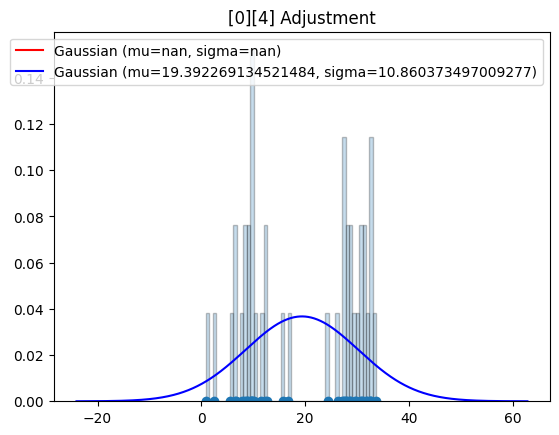

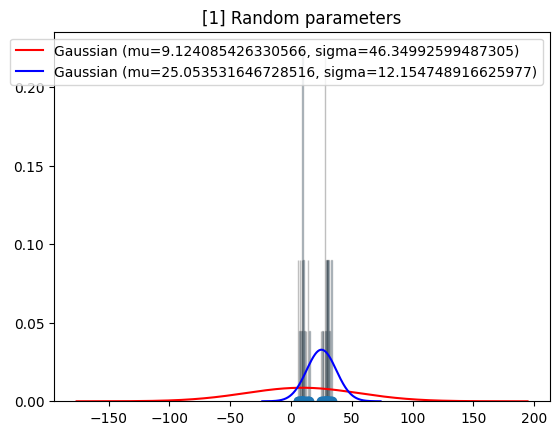

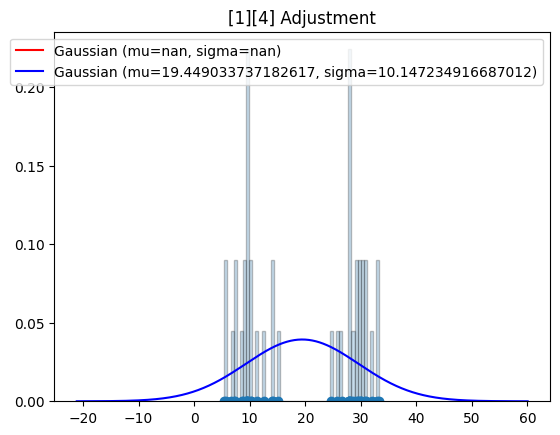

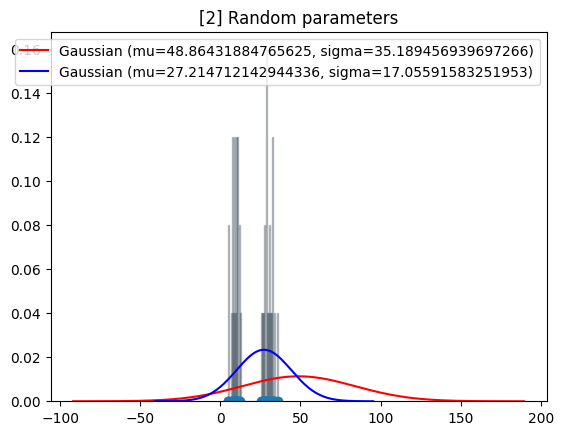

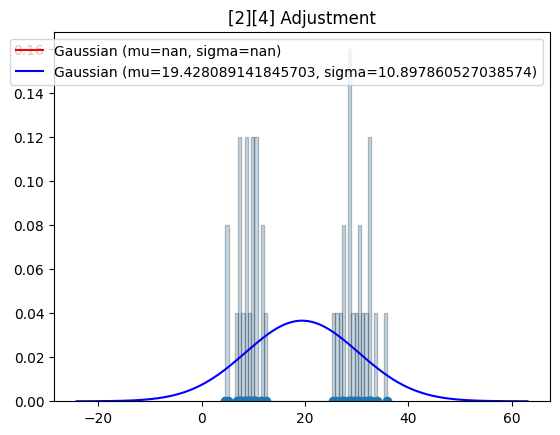

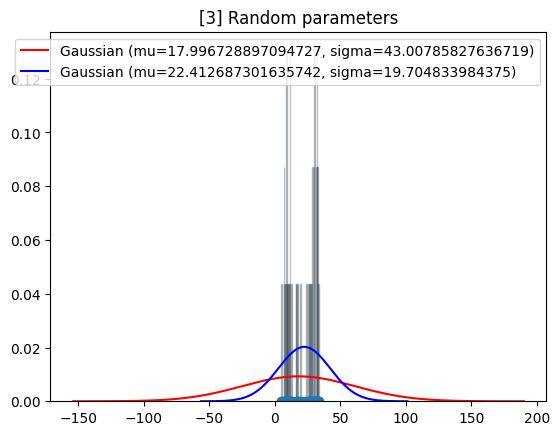

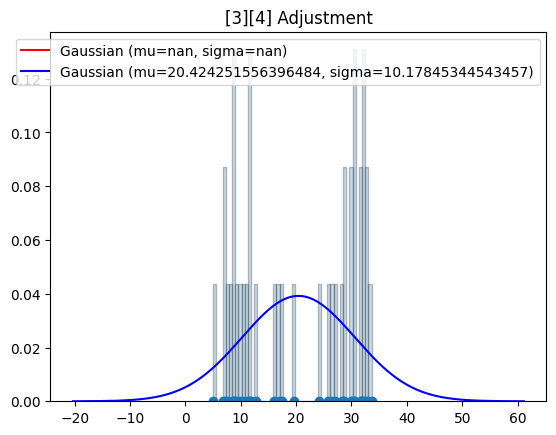

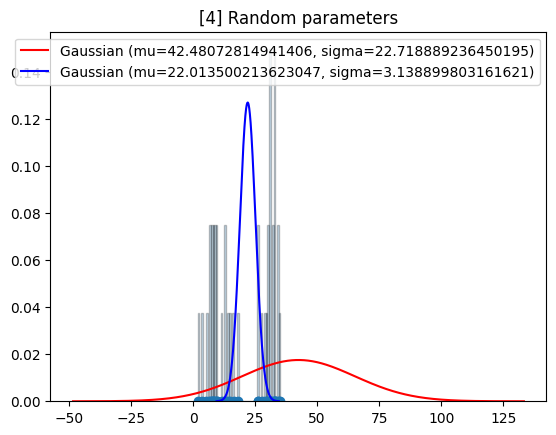

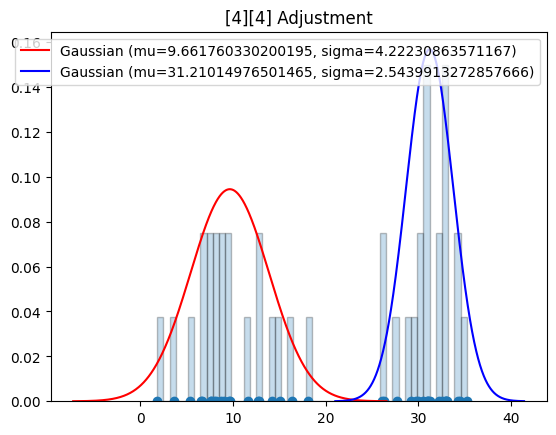

In [40]:
i_max = 5
i_adj_max = 5

mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

for i in range(i_max):
    X = generate_data(n, mu1, sigma1, mu2, sigma2)
    P = init_random_parameters()
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))

In [41]:
# 7)
def random_parameters_heuristic(X):
    mu = torch.mean(X, dim=0)
    sigma = torch.std(X, dim=0)
    mu_below = mu - sigma
    mu_above = mu + sigma
    mu1 = (mu - mu_below) * torch.rand(1) + mu_below
    sigma1 = (sigma / 2 - sigma / 4) * torch.rand(1) + sigma / 4
    mu2 = (mu_above - mu) * torch.rand(1) + mu
    sigma2 = (sigma / 2 - sigma / 4) * torch.rand(1) + sigma / 4
    return torch.tensor([[mu1, sigma1], [mu2, sigma2]])



PI = random_parameters_heuristic(X)
print(PI)

tensor([[12.0962,  3.8608],
        [23.6826,  3.9178]])


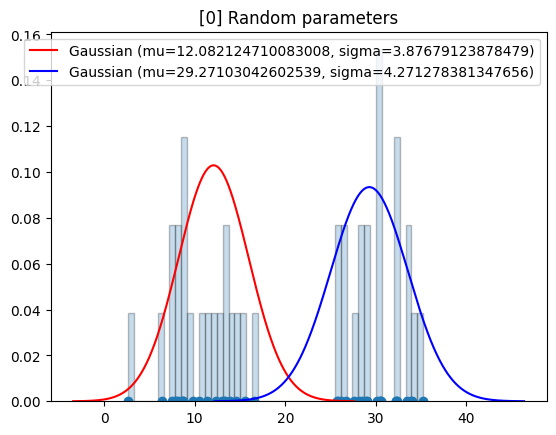

<ipython-input-37-5ded7ba2f913>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


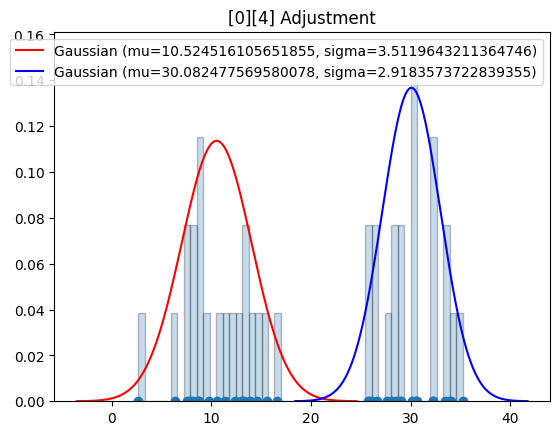

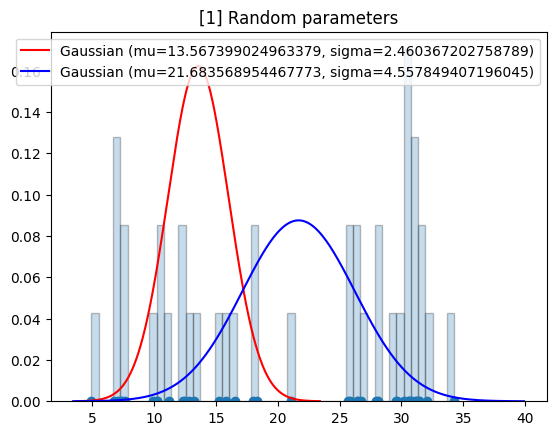

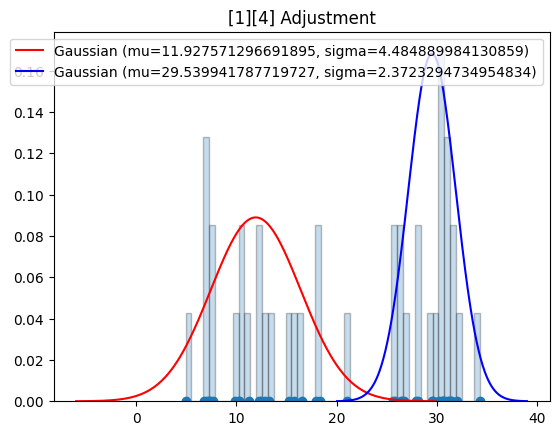

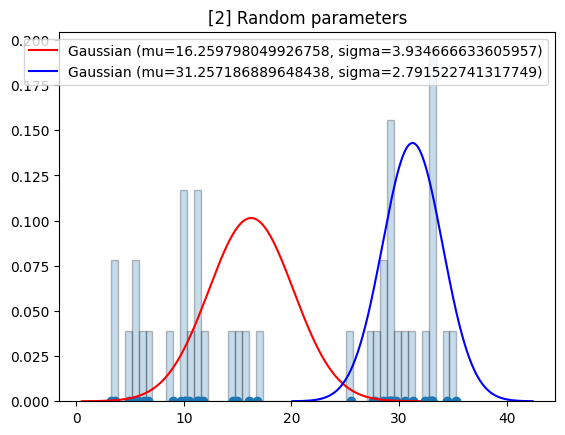

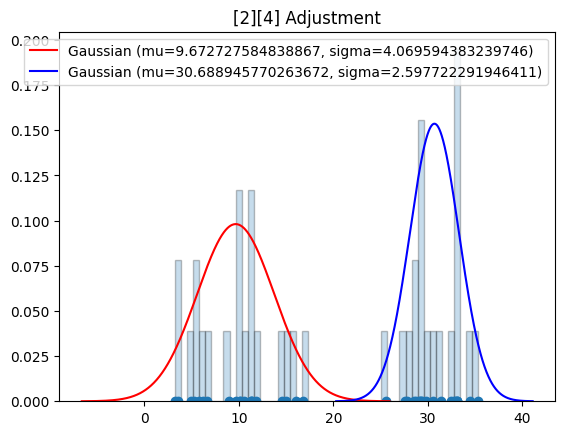

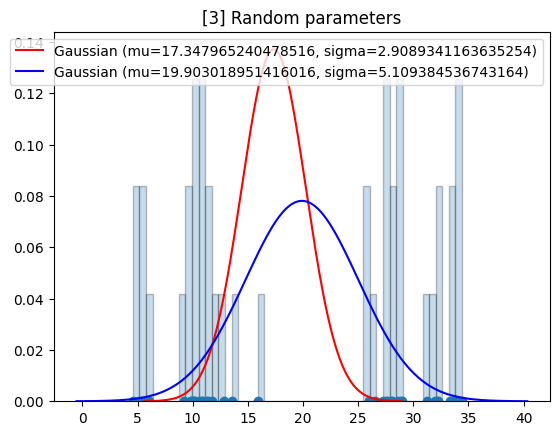

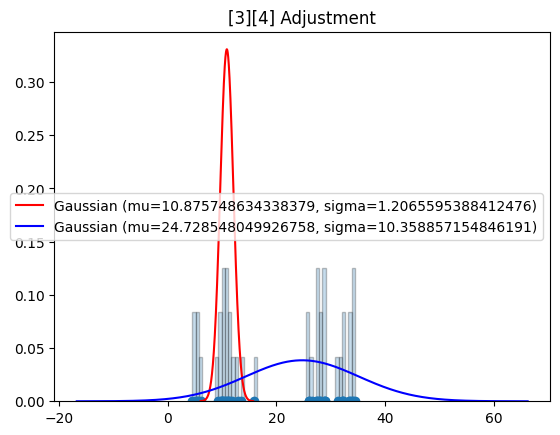

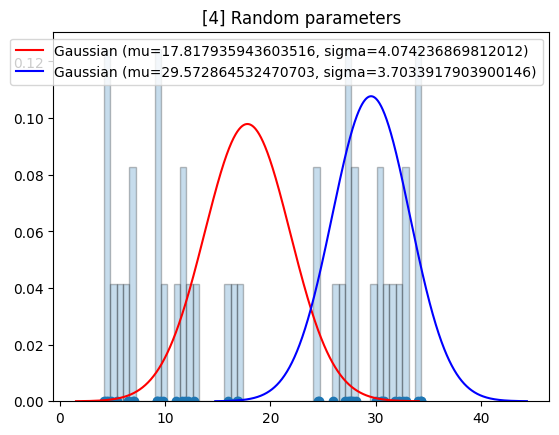

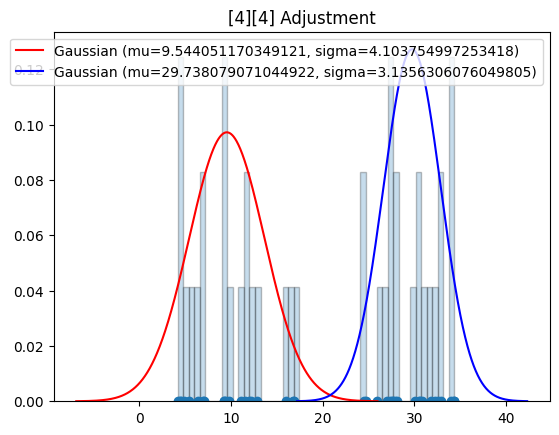

In [42]:
i_max = 5
i_adj_max = 5

mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

for i in range(i_max):
    X = generate_data(n, mu1, sigma1, mu2, sigma2)
    P = random_parameters_heuristic(X)
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))

#Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gamma)

In [43]:
# Util funcitons

def gamma_distribution_density_data(k, theta):
    """
        Given a k and a theta, this function returns a tuple representing the X and Y of the PDF

        params: k, theta <numbers>
        return: X, Y of the gamma distribution()
    """
    data = torch.linspace(k - 4*theta, k + 4*theta, 1000)

    gamma_distribution = ( (1/(gamma(k)*(theta**k))) * (data**(k-1)) * (torch.exp(-1 * data/theta)) )

    return data, gamma_distribution

def plot_gamma(X, k1, theta1, k2, theta2, title=''):
    # a) Scatter Plot with histograms
    # Histograms
    plt.hist(X, bins=50, alpha=0.25, density = True, histtype='bar', ec='black')
    # Scatter
    plt.scatter(X,torch.zeros(len(X)))
    # Density
    x1, gamma_density_1 = gamma_distribution_density_data(k1, theta1)
    #print('DEBUG: gamma_density_1', gamma_density_1)
    x2, gamma_density_2 = gamma_distribution_density_data(theta2, theta2)
    #print(gamma_distribution_density_data(alpha2, beta2))
    plt.plot(x1, gamma_density_1, label=f'Gamma (k={k1}, theta={theta1})', color='red')
    plt.plot(x2, gamma_density_2, label=f'Gamma (k={k2}, theta={theta2})', color='blue')
    plt.ylim(0, 2)
    plt.xlim(0,torch.max(X))
    #plt.plot.ylim = (0, 0.3)
    if len(title):
        plt.title(title)
    plt.legend()
    plt.show()

X =  tensor([1.0582e-03, 4.6496e-01, 1.9435e-01, 4.4410e-01, 1.2548e-01, 1.3401e-01,
        6.7795e-02, 4.9513e-01, 8.4089e-03, 8.2602e-02, 2.1163e-03, 1.5377e+00,
        6.2931e-02, 3.0318e-02, 8.9167e-04, 1.1490e-01, 2.8567e-03, 1.5864e-01,
        5.7436e-02, 3.8696e-02, 4.8724e-01, 1.3558e+00, 4.3379e-01, 8.5336e-01,
        5.4920e-01, 5.3356e-01, 4.9439e-02, 1.8968e-01, 5.1197e-01, 2.2843e-01,
        1.0210e+00, 8.4742e-01, 1.5376e+00, 3.0468e-01, 1.3997e+00, 9.4183e-02,
        3.8187e-01, 8.1019e-02, 4.4734e-01, 1.2722e+00])


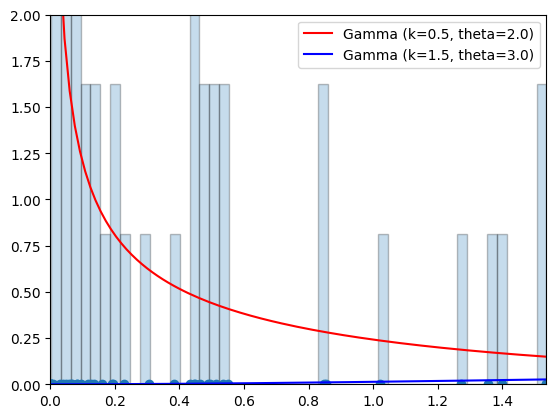

In [44]:
# 2)
k1 = .5
theta1 = 2.0
k2 = 1.5
theta2 = 3.0
# Generates data that follows two gamma distributions based on a set of parameters.
# parameters:
#    * k: shape
#    * theta:  scale
def generate_gamma_data(n, k1, theta1, k2, theta2):

  # Generate distributions
  gamma_dist1 = torch.distributions.Gamma(torch.tensor([k1]), torch.tensor([theta1]))
  gamma_dist2 = torch.distributions.Gamma(torch.tensor([k2]), torch.tensor([theta2]))

  # Take a sample from each dist
  gamma_sample1 = gamma_dist1.sample((n,1)).squeeze()
  gamma_sample2 = gamma_dist2.sample((n,1)).squeeze()

  # Concatenate the 2 samples
  X =  torch.cat((gamma_sample1, gamma_sample2))
  return X

X = generate_gamma_data(n, k1, theta1, k2, theta2)
print('X = ', X)

plot_gamma(X, k1, theta1, k2, theta2)


In [45]:
def calculate_log_likelihood_gamma_observation(x_n, k_n, theta_n):
    """
        Given a k, a theta, and an x observation this function returns the
        logarithmic likelyhood that said x belongs to the gamma distribution
        that results from that k and theta.

        params: k_n, theta_n, x_n <numbers>
        return: likelyhood
    """
    # logarithmic gamma distribution.
    if x_n > 0:
      a = -1*(k_n*torch.log(torch.tensor(gamma(k_n)*theta_n)))
      b = (k_n-1)*torch.log(x_n)
      c = -1*x_n/theta_n
      likelihood = a + b + c
    else:
      likelihood = 0

    return likelihood

In [46]:
# 2)
def init_random_parameters(k=2, range=5):
  """
      Generates randombly mu and sigma parameters
      params: k, range
      return: A Kx2 matrix where colum 0 corresponds to mu and column 1 to sigma
  """
  return torch.rand((k, 2))*range

P = init_random_parameters()
print('P = ', P)

def calculate_membership_dataset_gamma(X_dataset, Parameters_matrix, k=2):
  N = len(X_dataset)
  #print(N)
  M = torch.zeros(N, k)

  # for each element in X, calculate its likelyhood with each set of parameters from the Parameter Matrix and store the maximum
  for x in range(N):
    # set max likelyhood initially as a very low number (Me suena que esto también podría ponerse de una mejor forma)
    x_max_likelyhood = -999999999
    k_membership = 0
    # iterate over the parameter sets to find which set achieves max likelihood over x
    for k_index, parameters in enumerate(Parameters_matrix):
      #print('Debug: x = ', X_dataset[x], 'params = ', parameters[0], parameters[1])
      x_likelyhood = calculate_log_likelihood_gamma_observation(X_dataset[x], parameters[0], parameters[1])
      #print('Debug: x_likelyhood = ', x_likelyhood)
      if x_likelyhood > x_max_likelyhood:
        x_max_likelyhood = x_likelyhood
        #print('Debug: max likelyhood = ', x_max_likelyhood)
        k_membership = k_index
    M[x][k_membership] = 1

  return M

M = calculate_membership_dataset(X, P)
print('M = ', M)

P =  tensor([[2.9729, 3.7269],
        [4.3840, 2.6198]])
M =  tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


<ipython-input-37-5ded7ba2f913>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


In [47]:
def recalculate_parameters_gamma(X_dataset, Membership_data):
    # TODO: Can we improve this to use torch?
    membership_k1 = Membership_data[:,0]
    membership_k2 = Membership_data[:,1]
    k1_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k1[index] == 1])
    k2_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k2[index] == 1])
    #print(k1_tentative_values)
    k_1 = torch.mean(k1_tentative_values)**2 / torch.var(k1_tentative_values)
    k_2 = torch.mean(k2_tentative_values)**2 / torch.var(k2_tentative_values)
    theta_1 = torch.var(k1_tentative_values)/ torch.mean(k1_tentative_values)
    theta_2 = torch.var(k2_tentative_values)/ torch.mean(k2_tentative_values)
    return torch.tensor([[k_1, theta_1],[k_2, theta_2]])

print('Real parameters k1=[{},{}], k2=[{},{}] '.format(k1, theta1, k2, theta2))
print('Old P parameters: ', P)
P = recalculate_parameters(X, M)
print('New P parameters: ', P)

Real parameters k1=[0.5,2.0], k2=[1.5,3.0] 
Old P parameters:  tensor([[2.9729, 3.7269],
        [4.3840, 2.6198]])
New P parameters:  tensor([[0.4151, 0.4627],
        [   nan,    nan]])


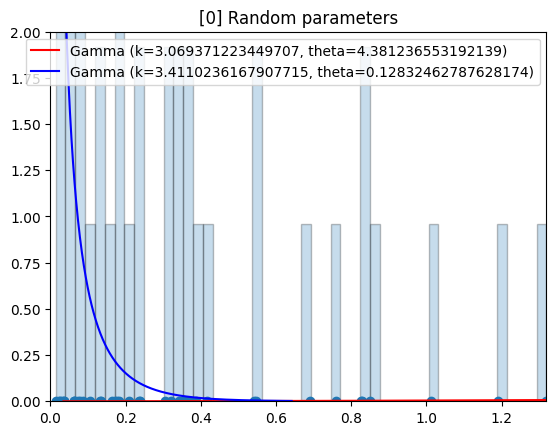

<ipython-input-45-585c22acc715>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = -1*(k_n*torch.log(torch.tensor(gamma(k_n)*theta_n)))


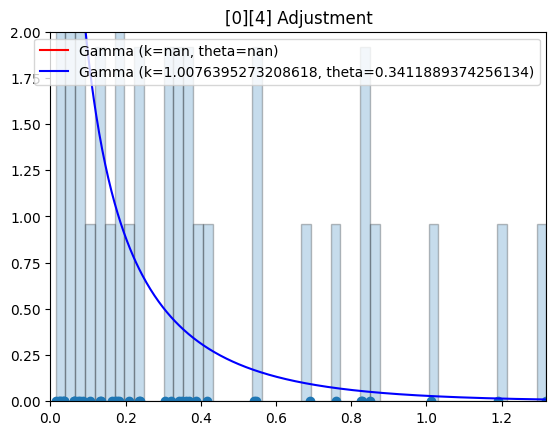

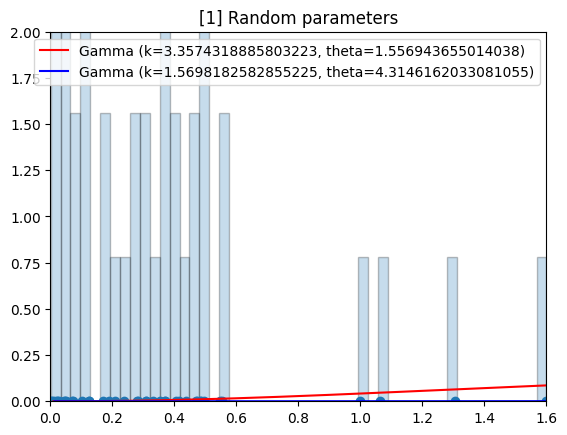

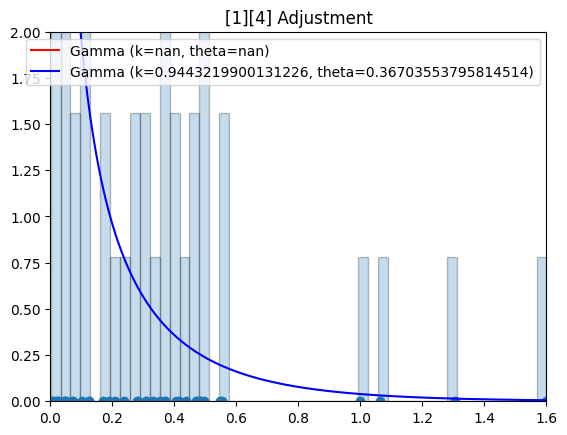

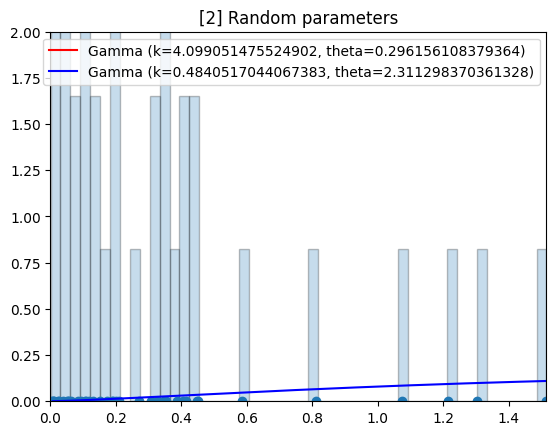

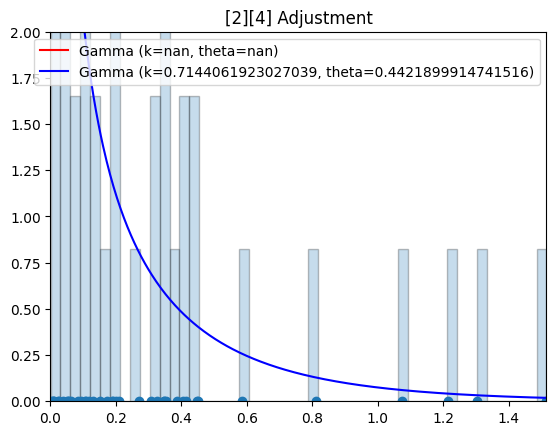

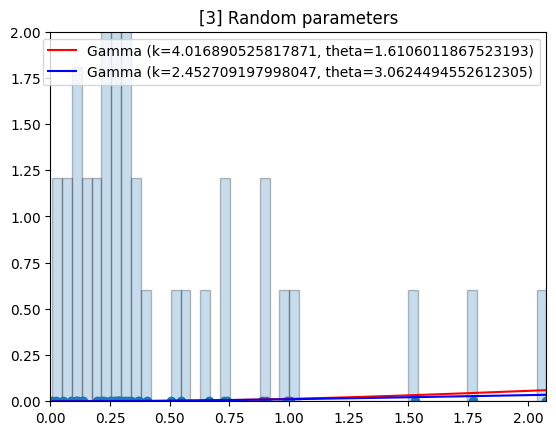

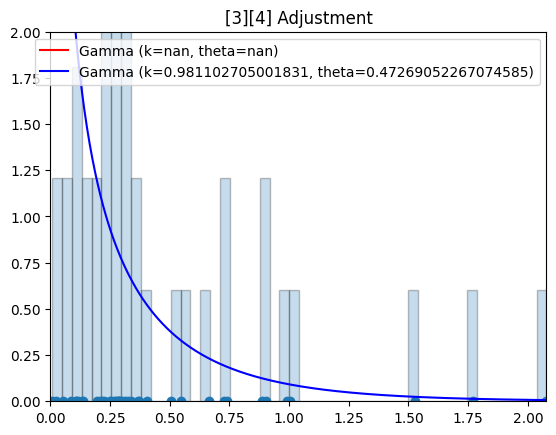

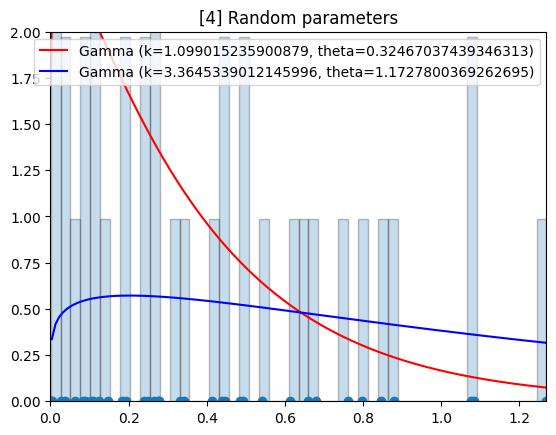

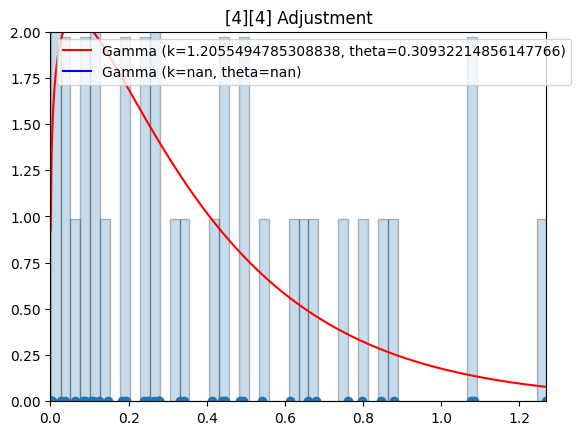

In [48]:
for i in range(i_max):
    X = generate_gamma_data(n, k1, theta1, k2, theta2)
    #P = random_parameters_heuristic(X)
    # params must be positive.
    P = init_random_parameters()
    plot_gamma(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset_gamma(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters_gamma(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot_gamma(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))